In [1]:
import sys
# sys.path.append('/home/abigaile-woodbury/Research/cp_reach')  # UPDATE path as needed
sys.path.append('/home/micah/Research/development/cp_reach')
import json
import numpy as np
import matplotlib.pyplot as plt
import cp_reach as cp

import cp_reach.satellite.invariant_set
import cp_reach.utils.plotting
import sympy as sp

# %load_ext autoreload
# %autoreload 2
import cp_reach.satellite.mission as sat_sim
from cyecca.symbolic import casadi_to_sympy
import casadi as ca
import cyecca.lie as lie
# import plotting
from cyecca.lie.group_se23 import se23, SE23Quat
# from cyecca.lie.algebra_so3 import so3
from cyecca.lie.group_se23 import SE23Quat


In [2]:
 B0 = sp.Matrix([
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
    ])

    # K = np.array([Kp Kd 0
    #                0 0  Kp])
    # Kp = 2.0
    # Kv = 3.0
    # Kq = 2.0
Kp, Kv, Kq = sp.symbols('Kp Kv Kq')
K = sp.Matrix([
    [Kp,0,0,Kv,0,0,0,0,0],
    [0,Kp,0,0,Kv,0,0,0,0],
    [0,0,Kp,0,0,Kv,0,0,0],
    [0,0,0,0,0,0,Kq,0,0],
    [0,0,0,0,0,0,0,Kq,0],
    [0,0,0,0,0,0,0,0,Kq]])

ref_acc = [3, 0, 0]
vec = ca.DM([0, 0, 0, ref_acc[0], ref_acc[1], ref_acc[2], 0, 0, 0])
alg = lie.se23.elem(vec)
ad = lie.se23.adjoint(alg)
ad_np = ca.DM(ad).full()
ad_sp = sp.Matrix(ad_np)
# print(ad_sp)

adC = sp.zeros(9)          # 9x9
adC[0:3, 3:6] = sp.eye(3)

A = -(ad_sp-adC) - B0@K

A = A.subs(Kp, 1)
A = A.subs(Kv, 1)
A = A.subs(Kq, 1)
A.eigenvals()

# A_np = np.array(sp.N(A).tolist(), dtype=float)
# A_np
# B0@K
# np.linalg.eigvals(A_np)

{-0.5 - 0.866025403784439*I: 3,
 -0.5 + 0.866025403784439*I: 3,
 -1.00000000000000: 3}

In [3]:
%%time
sat_burn = sat_sim.SatSimBurn()
t_vect = np.arange(0, 6, 0.01)
res = sat_burn.simulate(t_vect)

CPU times: user 8.92 ms, sys: 1.24 ms, total: 10.2 ms
Wall time: 9.71 ms


In [4]:
def do_burn_reference(t_vect):
    sat_burn = sat_sim.SatSimBurn()
    data = []
    p_index = sat_burn.model['p_index']
    sat_burn.model['p0_dict']['w_d_phase'] = 0
    sat_burn.model['p0_dict']['w_d_freq'] = 0
    sat_burn.model['p0_dict']['w_d_amp'] = 0
    sat_burn.model['p0_dict']['thrust'] = 30
    res = sat_burn.simulate(t_vect, integrator='rk')
    return res

def do_burn_monte_carlo(t_vect, n_runs=10):
    sat_burn = sat_sim.SatSimBurn()
    data = []
    for i in range(n_runs):
        p_index = sat_burn.model['p_index']
        sat_burn.model['p0_dict']['w_d_x_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_y_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_z_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_freq'] = 10**np.random.uniform(-2, 1)
        sat_burn.model['p0_dict']['w_d_amp'] = np.deg2rad(45)
        sat_burn.model['p0_dict']['thrust'] = 30

        res = sat_burn.simulate(t_vect, integrator='rk')
        data.append(res)
    return data

In [5]:
# Perform Monte Carlo Simulation for Burn Phase
t_burn_vect = np.arange(0, 20, 0.01)
data_burn_ref = do_burn_reference(t_burn_vect)
data_burn = do_burn_monte_carlo(t_vect=t_burn_vect, n_runs=100)

In [6]:
mass = 1
thrust = 30
acc = [thrust/mass, 0, 0]

In [7]:
ang_vel_points,lower_bound_omega,upper_bound_omega,omega_dist,dynamics_sol,inv_points,lower_bound,upper_bound,kinematics_sol = cp_reach.satellite.invariant_set.solve(2, acc)

Performing line search for optimal alpha...
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Oct 25 11:23:39 PM: Your problem has 10 variables, 46 constraints, and 0 parameters.
(CVXPY) Oct 25 11:23:39 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 25 11:23:39 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 25 11:23:39 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 25 11:23:39 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 25 11:23:39 PM:

TypeError: float() argument must be a string or a real number, not 'SO3QuatLieGroupElement'

In [17]:
import numpy as np
import casadi as ca

# X: 1x9 row (or 9-vector). Edit the numbers as needed.
X = np.array([0,0,0, 0,0,0, 0,0,0], dtype=float).reshape(9,)

# Lie algebra element -> group -> log back to algebra
xi = lie.se23.elem(ca.DM(X))          # se(2,3) element

g = xi.exp(lie.SE23Quat)             # SE(2,3) element
g.v
# xi_log = g.log(lie.SE23Quat)              # se(2,3) element with fields phi, v, p

# # Extract theta, v, p as plain NumPy
# theta = float(ca.norm_2(xi_log.phi))      # rotation angle
# v     = np.array(xi_log.v).astype(float).reshape(3,)
# p     = np.array(xi_log.p).astype(float).reshape(3,)

# theta, v, p


R3LieAlgebra: SX(@1=0, [@1, @1, @1])

In [9]:
print(lower_bound)
print(upper_bound)

[-7.55437222 -8.93325745 -9.1742011  -3.13967053 -1.527656   -3.13629775]
[7.89831001 8.93325745 9.1742011  3.1383056  1.527656   3.13629775]


In [25]:
def exp_ellipsoid_se23(M, n=2000, seed=0):
    """
    Sample the ellipsoid {xi | xi^T M xi = 1} in R^9 (pvq order),
    map each xi to SE_2(3) via cyecca's exp, and return a (9, n) array
    stacking [p_out; v_out; q_out] where q_out = vee(log(R)).
    """
    M = np.asarray(M, dtype=float)
    if M.shape != (9, 9):
        raise ValueError("M must be 9x9")

    # Cholesky on symmetrized M (fallback to eig if numerically singular)
    Me = 0.5 * (M + M.T)
    try:
        L = np.linalg.cholesky(Me)
    except np.linalg.LinAlgError:
        w, V = np.linalg.eigh(Me)
        eps = 1e-12 * max(1.0, np.linalg.norm(Me))
        w = np.clip(w, eps, np.inf)
        L = V @ np.diag(np.sqrt(w))

    # Uniform samples on S^8, boundary points xi = L^{-T} s
    rng = np.random.default_rng(seed)
    S = rng.normal(size=(9, n))
    S /= np.linalg.norm(S, axis=0, keepdims=True) + 1e-15
    Xi = np.linalg.solve(L.T, S)  # (9, n)

    out = np.zeros((9, n), dtype=float)

    for i in range(n):
        p = ca.DM(Xi[0:3, i])
        v = ca.DM(Xi[3:6, i])
        q = ca.DM(Xi[6:9, i])  # axis-angle (so(3))

        # algebra element ξ (pvq), then group element X = exp(ξ)
        xi = se23.elem(ca.vertcat(p, v, q))
        X  = SE23Quat.exp(xi)

        # Extract p, v, and log(R) -> axis-angle
        p_out = ca.DM(X.p.param).full().reshape(-1)
        v_out = ca.DM(X.v.param).full().reshape(-1)
        xi_R  = so3.log(X.R)  # so(3) algebra element
        q_out = ca.DM(xi_R.param).full().reshape(-1)

        out[0:3, i] = p_out
        out[3:6, i] = v_out
        out[6:9, i] = q_out

    return out  # shape (9, n)


In [9]:
mu1 = kinematics_sol['mu1']
P_kin = kinematics_sol['P']
val_kin = mu1 * omega_dist**2
P_kin_scaled = P_kin / val_kin

NameError: name 'kinematics_sol' is not defined

In [26]:
exp_ellipsoid_se23(M=P_kin_scaled, n=2000)

NameError: name 'so3' is not defined

In [12]:
def plot3DInvSet(points):
    plt.figure(figsize=(14,7))
    ax1 = plt.subplot(121, projection='3d', proj_type='ortho', elev=40, azim=20)
    ax1.plot3D(points[0, :], points[1, :], points[2, :],'g')
    ax1.set_xlabel('$\\theta_x$, rad')
    ax1.set_ylabel('$\\theta_y$, rad')
    ax1.set_zlabel('$\\theta_z$, rad', labelpad=1)
    ax1.set_title('Attitude Invariant Set', fontsize=20)

    plt.axis('auto')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
def plot2DInvSet(points):
    plt.figure(figsize=(14,7))
    ax1 = plt.subplot(121)
    ax1.plot(points[0, :], points[1, :],'g')
    ax1.set_xlabel('$\\theta_x$, rad')
    ax1.set_ylabel('$\\theta_y$, rad')
    ax1.set_title('Invariant Set in Lie Algebra', fontsize=20)

    plt.axis('auto')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

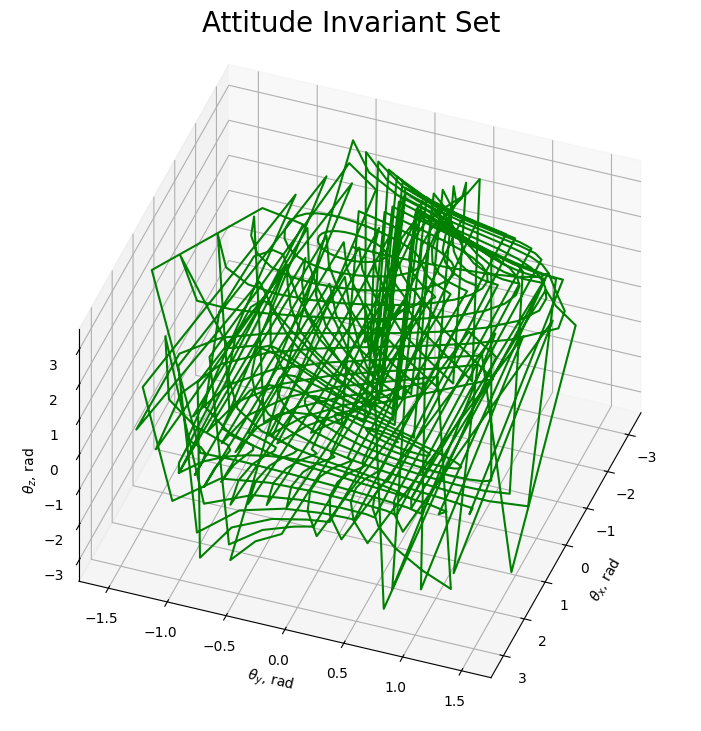

In [13]:
ypr = inv_points[3:6]
ypr.shape
plot3DInvSet(ypr)

In [11]:
# # Run disturbance + Lyapunov-based reachability bounds
# results = log_satellite.disturbance(satellite_config)

# print("Inner Bound (SO3):", results['mu_inner'])
# print("Outer Bound (SE3):", results['mu_outer'])
# print("Omega Bound:", results['inner_bound'])


In [12]:
# # Compute invariant points in SE(3)
# points, theta = flowpipe.se23_invariant_set_points_theta(
#     sol=results,
#     N=20,
#     w1=satellite_config['thrust_disturbance'],
#     omegabound=results['inner_bound'],
#     beta=results['outer_beta']
# )
# inv_points = flowpipe.exp_map(points, theta)


In [13]:
# # Plot invariant set
# def plot2DInvSet(points, inv_points):
#     plt.figure(figsize=(14, 7))
#     plt.rcParams.update({'font.size': 12})

#     ax1 = plt.subplot(121)
#     ax1.plot(points[0, :], points[1, :], 'g')
#     ax1.set_xlabel(r'$\zeta_x$ [km]')
#     ax1.set_ylabel(r'$\zeta_y$ [km]')
#     ax1.set_title('Lie Algebra (log map)')
#     ax1.axis('equal')
#     ax1.grid(True)

#     ax2 = plt.subplot(122)
#     ax2.plot(inv_points[0, :], inv_points[1, :], 'g')
#     ax2.set_xlabel(r'$\eta_x$ [km]')
#     ax2.set_ylabel(r'$\eta_y$ [km]')
#     ax2.set_title('Lie Group (exp map)')
#     ax2.axis('equal')
#     ax2.grid(True)

#     plt.tight_layout()
#     plt.show()

# plot2DInvSet(points, inv_points)


In [14]:
# # Generate flowpipes and plot
# flowpipes_list, nominal_traj = flowpipe.flowpipes(
#     ref=ref,
#     step=1,
#     w1=satellite_config['thrust_disturbance'],
#     omegabound=1,
#     sol=results,
#     axis='xy'
# )

# flowpipe.plot_flowpipes(nominal_traj, flowpipes_list, axis='xy')


NameError: name 'flowpipe' is not defined

In [15]:
# import os

# base = '/home/abigaile-woodbury/Research/cp_reach/cp_reach'
# print('__init__.py in cp_reach:', os.path.isfile(f'{base}/__init__.py'))
# print('__init__.py in sim:', os.path.isfile(f'{base}/sim/__init__.py'))
# print('__init__.py in satellite:', os.path.isfile(f'{base}/satellite/__init__.py'))
# print('__init__.py in flowpipe:', os.path.isfile(f'{base}/flowpipe/__init__.py'))
